## Dataset
The dataset was obtained downloading free-to-share images from the web using the keywords "russell's viper" and "oriental whip snake".Images are automatically downloaded using javascript and python scripts.

After a quick visual cleanup, the dataset contains 300 images of russell's viper and 320 images of oriental whip snake. After downloading those images, we preprocessed them to be 128x128 pixels, generated the train and test datasets and stored them in an HDF5 file.

In [1]:
import numpy as np
import h5py as h5
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from matplotlib import pyplot as plt
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


### Understanding the dataset


In [2]:
# Extracting the train dataset from the h5 file.
f = h5.File("./dataset/train_set.hdf5",'r')
print("Stored data:",list(f.keys()))
# Storing the original data "permanently".
images_train_orig = f["images_train"][()]
labels_train_orig = f["labels_train"][()]
f.close()
# Extracting the dev dataset from the h5 file.
f = h5.File("./dataset/dev_set.hdf5",'r')
print("Stored data:",list(f.keys()))
# Storing the original data "permanently".
images_dev_orig = f["images_dev"][()]
labels_dev_orig = f["labels_dev"][()]
f.close()

Stored data: ['images_train', 'labels_train']
Stored data: ['images_dev', 'labels_dev']


In [3]:
print("Train set")
print("Images shape:", images_train_orig.shape)
#print("Images dtype:", images_train_orig.dtype)
print("Min, max and mean pixel values:", images_train_orig.min(),"-",
      images_train_orig.max(),"-","{:5.1f}".format(images_train_orig.mean()))
print("Labels shape:", labels_train_orig.shape)
#print("Labels dtype:", labels_train_orig.dtype)

Train set
Images shape: (496, 128, 128, 3)
Min, max and mean pixel values: 0 - 255 -  93.4
Labels shape: (496,)


In [4]:
print("Test set")
print("Images shape:", images_dev_orig.shape)
#print("Images dtype:", images_dev_orig.dtype)
print("Min, max and mean pixel values:", images_dev_orig.min(),"-",
      images_dev_orig.max(),"-","{:5.1f}".format(images_dev_orig.mean()))
print("Labels shape:", labels_dev_orig.shape)
#print("Labels dtype:", labels_dev_orig.dtype)

Test set
Images shape: (124, 128, 128, 3)
Min, max and mean pixel values: 0 - 255 -  97.1
Labels shape: (124,)


In this dataset, russell's viper have label 1 and oriental whipsnake have label 0. So let's take a look at the pictures.

In [5]:
def species(i):
    if i == 1:
        name = "russell's viper"
    else:
        name = "oriental whipsnake"
    return name

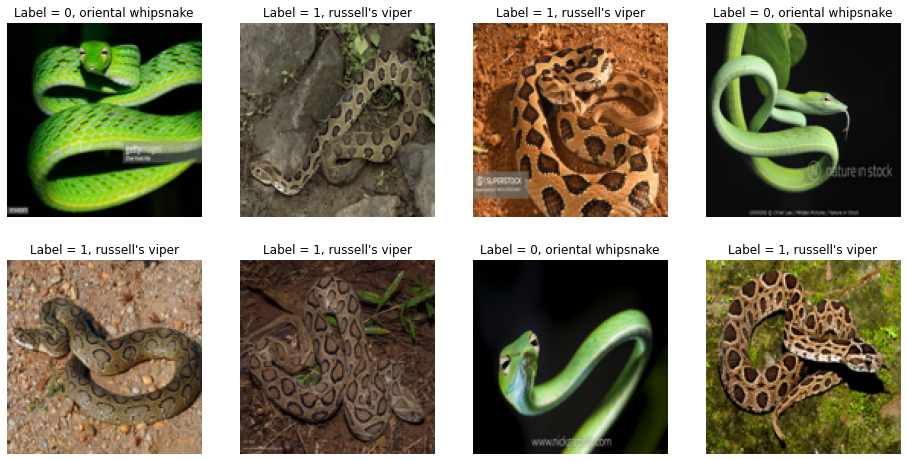

In [6]:
# create figure
fig = plt.figure(figsize=(16, 8))
# setting values to rows and column variables
rows = 2
columns = 4
image_index = 121
for x in range(1,9):
    fig.add_subplot(rows, columns, x)
    # showing image
    plt.imshow(images_train_orig[image_index])
    plt.axis('off')
    plt.title("Label = " + str(labels_train_orig[image_index]) +", "+str(species(labels_train_orig[image_index])))
    image_index += 1
    

### Preparing the data
As we saw earlier, images are stored using 0-255 pixel values. We will scale them to 0-1 float values.
Also, we linearize the pixel values on width, height and color channels for each image.

In [7]:
# Copying the original data for manipulation.
images_train = images_train_orig
labels_train = labels_train_orig.reshape([1,len(labels_train_orig)])
images_dev = images_dev_orig
labels_dev = labels_dev_orig.reshape([1,len(labels_dev_orig)])
# Scaling the data
images_train = images_train/255
images_train = images_train.reshape((len(images_train),-1))# -1 refers to unknown dimension that reshape fun will calculate
images_train = images_train.transpose()
images_dev = images_dev/255
images_dev = images_dev.reshape((len(images_dev),-1))
images_dev = images_dev.transpose()
# Shapes
imsize = images_train.shape[0]
print("Images input size")
print(imsize)
print("Images train shape")
print(images_train.shape)
print(labels_train.shape)
print("Images test shape")
print(images_dev.shape)
print(labels_dev.shape)

Images input size
49152
Images train shape
(49152, 496)
(1, 496)
Images test shape
(49152, 124)
(1, 124)


## Logistic Regression
Logistic regression (LR) is one of the simplest classification methods available, and shares important key ideas with shallow and deep neural networks.

### Building the model
Build the model in tensorflow.

In [8]:
# Create placeholder for images, call it X.
# tf.reset_default_graph() #deprecated
# tf.reset_default_graph() #deprecated
tf.compat.v1.reset_default_graph()
X = tf.compat.v1.placeholder(tf.float32, shape=(imsize,None))
Y = tf.compat.v1.placeholder(tf.float32,shape=(1,None))
# Create weights and biases. Initialize to zero.
W = tf.get_variable("W", [1,imsize], initializer=tf.zeros_initializer())
b = tf.get_variable("b", [1],initializer=tf.zeros_initializer())
# Make the affine transformation
logits = tf.add(tf.matmul(W,X),b)
# Calculating the cost
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y,logits=logits))

### Training the model
Training a logistic regression is pretty straightforward as demonstrated below. We use gradient descent optimizer, considering the gradient on the mean logloss over the whole trainning dataset. We also compute and store the cost on the dev dataset to analize the out-of-sample error.

In [9]:
epochs = 500
learning_rate = 0.001
# Creating the optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# Initializing global variables
init = tf.global_variables_initializer()
# Running session
with tf.Session() as sess:
    sess.run(init)
    costs_train = []
    costs_dev = []
    loss_trace = []
    for epoch in range(epochs):
        _,epoch_cost = sess.run([optimizer,cost],feed_dict={X:images_train,Y:labels_train})
        # underscore is used to ingore returned variable at this part.
        temp_loss = sess.run(cost, feed_dict={X: images_train, Y: labels_train})
        loss_trace.append(temp_loss)
        costs_train.append(epoch_cost)
        cost_dev = sess.run(cost,feed_dict={X:images_dev,Y:labels_dev})
        print(epoch,epoch_cost, cost_dev)
        costs_dev.append(cost_dev)
    Weights, Bias = sess.run([W,b])

0 0.69314724 0.715089
1 0.6817911 0.6688521
2 0.668235 0.6859737
3 0.65803605 0.64795154
4 0.64673054 0.66087425
5 0.6375341 0.6297992
6 0.62791896 0.6389985
7 0.61964023 0.61391824
8 0.6113458 0.61985344
9 0.60390913 0.59989506
10 0.59665793 0.6030548
11 0.5899746 0.58735645
12 0.58354753 0.5882606
13 0.5775155 0.575982
14 0.5717409 0.57515645
15 0.5662577 0.5655194
16 0.56100464 0.56346196
17 0.5559792 0.55579287
18 0.55115163 0.5529372
19 0.5465108 0.5466904
20 0.5420397 0.54338425
21 0.53772736 0.5381453
22 0.5335624 0.5346437
23 0.52953607 0.5301152
24 0.52563983 0.52658945
25 0.5218663 0.52256846
26 0.5182092 0.5191227
27 0.514662 0.5154757
28 0.51121944 0.5121657
29 0.5078763 0.50880724
30 0.5046276 0.5056576
31 0.501469 0.50253284
32 0.49839652 0.49954966
33 0.49540597 0.49662268
34 0.49249384 0.49380153
35 0.4896567 0.4910479
36 0.48689136 0.4883806
37 0.48419473 0.48578203
38 0.48156393 0.48325828
39 0.47899646 0.48080054
40 0.4764895 0.4784098
41 0.4740409 0.47608113
42 0.47

329 0.2843829 0.34237438
330 0.28413558 0.34228915
331 0.28388882 0.34220487
332 0.283643 0.34212086
333 0.28339767 0.34203735
334 0.28315324 0.34195402
335 0.28290963 0.34187183
336 0.28266656 0.34178966
337 0.28242433 0.34170824
338 0.28218287 0.3416272
339 0.2819422 0.34154624
340 0.28170204 0.3414666
341 0.28146282 0.34138703
342 0.2812241 0.341308
343 0.2809862 0.34122914
344 0.280749 0.34115094
345 0.28051254 0.34107304
346 0.28027666 0.3409958
347 0.28004143 0.34091905
348 0.27980706 0.34084234
349 0.27957314 0.3407664
350 0.27934006 0.3406907
351 0.2791077 0.34061563
352 0.27887586 0.34054092
353 0.27864468 0.34046674
354 0.2784144 0.34039256
355 0.27818438 0.34031942
356 0.27795535 0.3402461
357 0.2777269 0.34017375
358 0.27749908 0.3401012
359 0.27727184 0.34002966
360 0.27704516 0.33995798
361 0.27681923 0.33988696
362 0.27659386 0.33981633
363 0.27636915 0.33974618
364 0.27614513 0.33967626
365 0.2759216 0.33960667
366 0.27569872 0.33953756
367 0.27547655 0.33946875
368 0.2

### Visualization of loss reduction

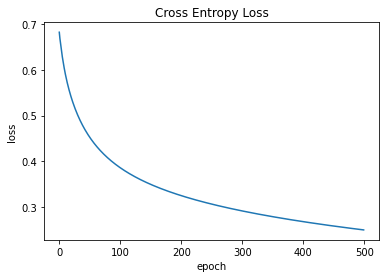

In [10]:
plt.plot(loss_trace)
plt.title('Cross Entropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Error curves
We plot the train and test set error stored during training.

Text(0, 0.5, 'Mean log loss')

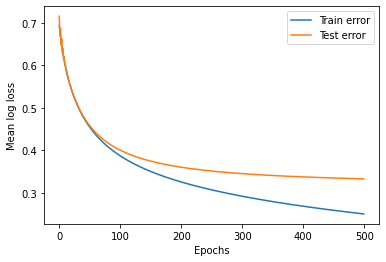

In [11]:
train_curve, = plt.plot(costs_train, label = 'Train error')
test_curve,  = plt.plot(costs_dev, label = 'Test error')
plt.legend(handles=[train_curve,test_curve])
plt.xlabel('Epochs')
plt.ylabel('Mean log loss')

### Model accuracy
We begin by creating two simple functions. One to calculate the predicted values by the trained model given a set of pictures and the parameters trained by the model, and another to calculate the percentage of right predictions given a 0.5 probability threshold.

In [12]:
def predict(x,w,b):
    z = np.dot(w,x)+b
    probs = 1/(1+np.exp(-z))
    # z = tf.add(tf.matmul(w, x),b)
    # probs = tf.sigmoid(z)
    y_pred = (probs > 0.5).astype(int)
    return y_pred

In [13]:
def accuracy(label,y_pred):
    acc = np.mean(np.equal(label,y_pred))
    return acc

We can now assess the model's accuracy on both sets.

In [14]:
y_train_pred = predict(images_train,Weights,Bias)
acc = accuracy(labels_train,y_train_pred)
print("Train set accuracy:", acc)
y_dev_pred = predict(images_dev,Weights,Bias)
acc = accuracy(labels_dev,y_dev_pred)
print("Test set accuracy:",acc)

Train set accuracy: 0.9314516129032258
Test set accuracy: 0.8709677419354839


## Making the prediction
Make the prediction on the training set.

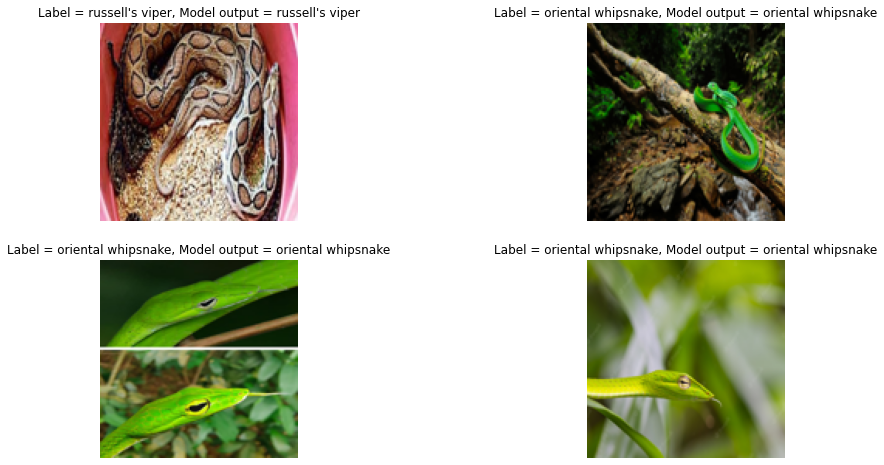

In [15]:
fig = plt.figure(figsize=(16, 8))
rows = 2
columns = 2
image_index = 0
for x in range(1,5):
    sample = images_train[:,image_index]
    target = labels_train[0,image_index]
    prediction = predict(sample,Weights,Bias)
    fig.add_subplot(rows, columns, x)
    plt.imshow(images_train_orig[image_index])
    plt.axis('off')
    plt.title("Label = " + str(species(target)) +", Model output = "+str(species(prediction)))
    image_index += 1

Make the prediction on the test set.

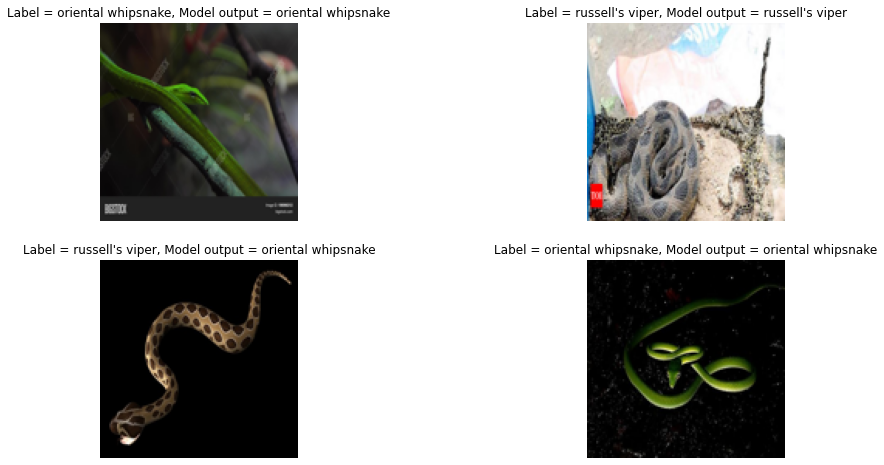

In [17]:
fig = plt.figure(figsize=(16, 8))
rows = 2
columns = 2
image_index = 30
for x in range(1,5):
    sample = images_dev[:,image_index]
    target = labels_dev[0,image_index]
    prediction = predict(sample,Weights,Bias)
    fig.add_subplot(rows, columns, x)
    plt.imshow(images_dev_orig[image_index])
    plt.axis('off')
    plt.title("Label = " + str(species(target)) +", Model output = "+str(species(prediction)))
    image_index += 1